In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, KFold

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve

from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix


from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pickle
from sklearn.metrics import ConfusionMatrixDisplay
import lightgbm as lgb

In [2]:
xtrain = pd.read_parquet("../data/xtrain.parquet")
ytrain = pd.read_parquet("../data/ytrain.parquet")['fatality']
xtest = pd.read_parquet("../data/xtest.parquet")
ytest = pd.read_parquet("../data/ytest.parquet")['fatality']
xtrain_smote = pd.read_parquet("../data/xtrain_smote.parquet")
ytrain_smote = pd.read_parquet("../data/ytrain_smote.parquet")['fatality']

In [3]:
clf = lgb.LGBMClassifier(n_jobs=-1, random_state=0)
clf.fit(xtrain, ytrain)

LGBMClassifier(random_state=0)

In [4]:
with open('../models/LightGBM.pickle', 'wb') as f:
    pickle.dump(clf, f)

In [5]:
# Para no tener que ejecutar, saltarse el fit y ejecutar a partir de aquí
with open('../models/LightGBM.pickle', 'rb') as f:
    clf = pickle.load(f)

In [6]:
ypred = clf.predict(xtest)
ypred_proba = clf.predict_proba(xtest)

In [7]:
def evaluate_model(ytest, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(ytest, ypred_proba[:, 1])))
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(ytest, ypred)))

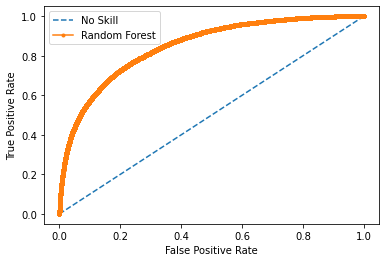

Best Threshold=0.014631, G-Mean=0.764


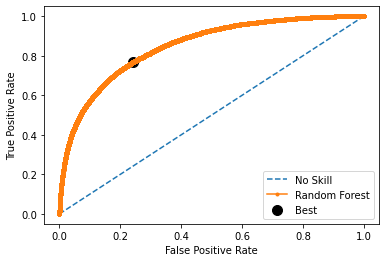

ROC-AUC score of the model: 0.8485746431939847
Accuracy of the model: 0.7598337040593885

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.76      0.86    797650
           1       0.05      0.77      0.09     12472

    accuracy                           0.76    810122
   macro avg       0.52      0.76      0.48    810122
weighted avg       0.98      0.76      0.85    810122


Confusion matrix: 
[[605987 191663]
 [  2901   9571]]



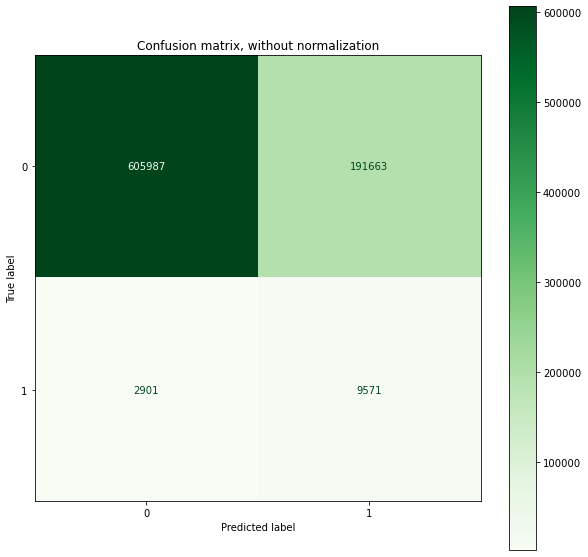

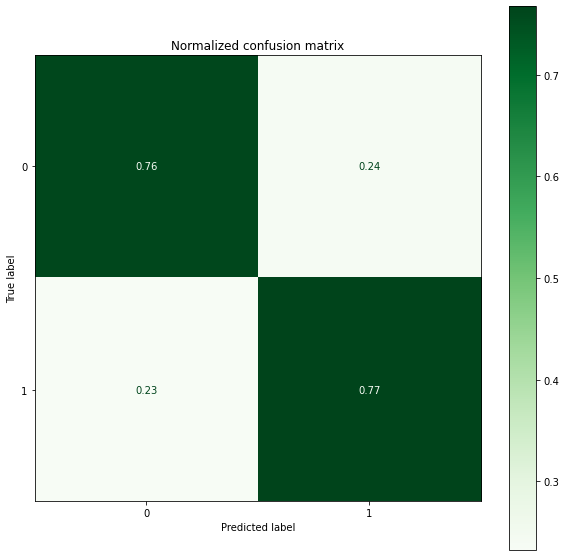

In [8]:
# keep probabilities for the positive outcome only
yhat = ypred_proba[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
plt.scatter(fpr[ix], tpr[ix], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)
evaluate_model(ytest,ypred_new_threshold,ypred_proba)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay.from_predictions(ytest, ypred_new_threshold,
                                 cmap=plt.cm.Greens,
                                 normalize=normalize,
                                 ax = ax)
    ax.set_title(title)

# LightGBM con SMOTE

In [9]:
clf = lgb.LGBMClassifier(n_jobs=-1, random_state=0)
clf.fit(xtrain_smote, ytrain_smote)

LGBMClassifier(random_state=0)

In [10]:
with open('../models/LightGBM_smote.pickle', 'wb') as f:
    pickle.dump(clf, f)

In [11]:
# Para no tener que ejecutar, saltarse el fit y ejecutar a partir de aquí
with open('../models/LightGBM_smote.pickle', 'rb') as f:
    clf = pickle.load(f)

In [12]:
ypred = clf.predict(xtest)
ypred_proba = clf.predict_proba(xtest)

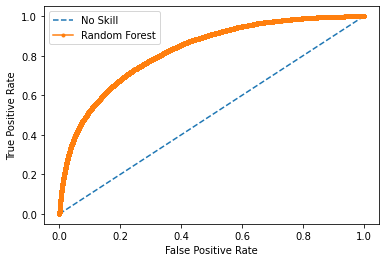

Best Threshold=0.027395, G-Mean=0.742


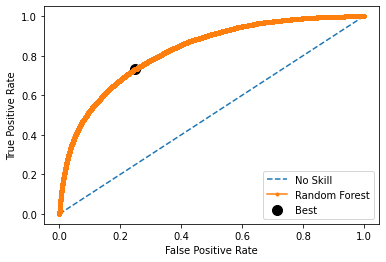

ROC-AUC score of the model: 0.8257914950073636
Accuracy of the model: 0.7528174768738536

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.75      0.86    797650
           1       0.04      0.73      0.08     12472

    accuracy                           0.75    810122
   macro avg       0.52      0.74      0.47    810122
weighted avg       0.98      0.75      0.85    810122


Confusion matrix: 
[[600760 196890]
 [  3358   9114]]



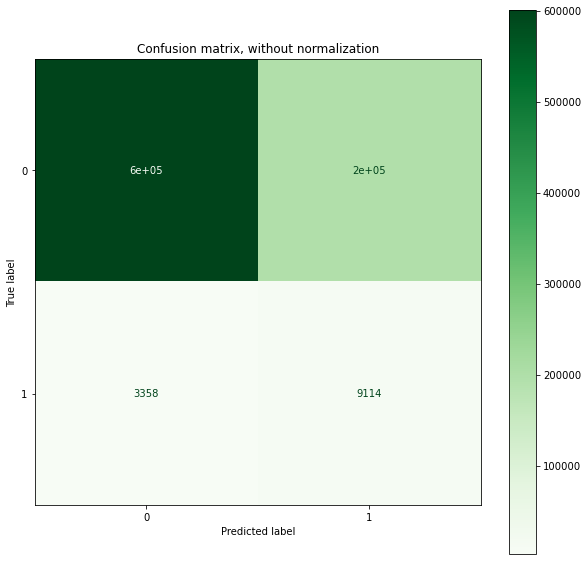

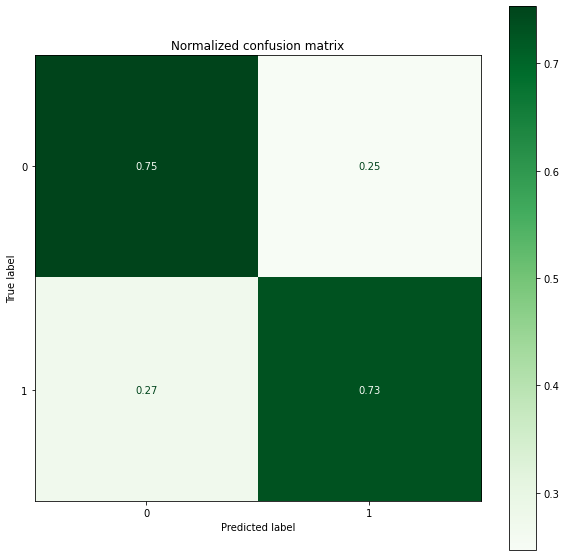

In [13]:
# keep probabilities for the positive outcome only
yhat = ypred_proba[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
plt.scatter(fpr[ix], tpr[ix], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)
evaluate_model(ytest,ypred_new_threshold,ypred_proba)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay.from_predictions(ytest, ypred_new_threshold,
                                 cmap=plt.cm.Greens,
                                 normalize=normalize,
                                 ax = ax)
    ax.set_title(title)